# feature set 4 chromosomes 2, 3, 4 

## In this notebook:

* single input dataframe 
* using feature set 43 (2+mutation counts)
* random forest
* only training/test split, no epochs 
* aucuracy assessement of RF: 
* feature importance for RF (mostly just amino acid position)

In [1]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr2-4_featureset4.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
#df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (13820, 15)
shape after dropping all data with score = '.' (13820, 15)
shape after dropping Unk (13820, 15)


In [2]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos codonpos  Ancestral_allele  Polyphen2_HVAR_pred  \
chr pos       ref alt                                                          
2   222220292 G   A      341        1                 2                    0   
4   95114733  T   C       53        1                 2                   -2   
2   178694626 C   T    10150        1                 2                    0   

                        GenoCanyon_score HUVEC_fitCons_score  \
chr pos       ref alt                                          
2   222220292 G   A    0.999999999414244            0.564101   
4   95114733  T   C    0.999999997815507              0.6691   
2   178694626 C   T    0.999728534038663            0.542086   

                            ExAC_cnv.score  SORVA_LOF_MAF0.005_HetOrHom  \
chr pos       ref alt                                                     
2   222220292 G   A       1.41369465212203                     0.001198   
4   95114733  T   C    -0.06784

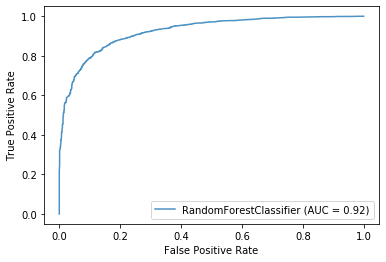

Confusion matrix: 
 [[ 692  284]
 [ 191 2246]]
Accuracy: 0.8608262525637269
Recall TP/(TP+FN): [0.70901639 0.92162495]
Precision TP/(TP+FP): [0.78369196 0.88774704]
F1: [0.74448628 0.90436883]
Feature ranking:
1. feature 3 (0.167484)
Polyphen2_HVAR_pred
2. feature 0 (0.160132)
aapos
3. feature 4 (0.103876)
GenoCanyon_score
4. feature 13 (0.070748)
Mutation<100kb
5. feature 12 (0.068859)
Mutation<30kb
6. feature 11 (0.066173)
Mutation<10kb
7. feature 5 (0.063548)
HUVEC_fitCons_score
8. feature 6 (0.062768)
ExAC_cnv.score
9. feature 10 (0.061696)
Mutation<5kb
10. feature 9 (0.061045)
Mutation<1kb
11. feature 7 (0.050559)
SORVA_LOF_MAF0.005_HetOrHom
12. feature 1 (0.050176)
codonpos
13. feature 8 (0.007109)
Essential_gene_CRISPR
14. feature 2 (0.005829)
Ancestral_allele


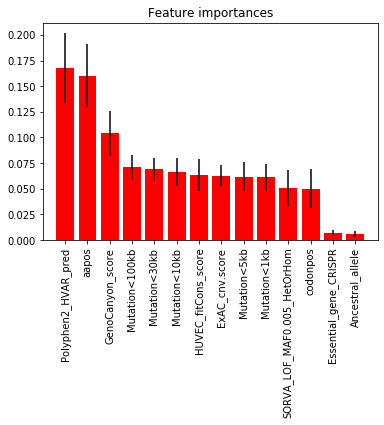

In [7]:
# Try a random forest:

forest = RandomForestClassifier(n_estimators=1000, random_state=42)
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()

### result of exp 11: n=10
Confusion matrix: 
 [[ 733  243]
 [ 251 2186]]
Accuracy: 0.855259302666276
Recall TP/(TP+FN): [0.75102459 0.89700451]
Precision TP/(TP+FP): [0.7449187  0.89995883]
F1: [0.74795918 0.89847924]
    
    
### result of exp 11: n=100
Confusion matrix: 
 [[ 687  289]
 [ 196 2241]]
Accuracy: 0.8578962789334896
Recall TP/(TP+FN): [0.70389344 0.91957325]
Precision TP/(TP+FP): [0.77802945 0.88577075]
F1: [0.73910705 0.90235555]


### result of exp 11: n=1000
Confusion matrix: 
 [[ 692  284]
 [ 191 2246]]
Accuracy: 0.8608262525637269
Recall TP/(TP+FN): [0.70901639 0.92162495]
Precision TP/(TP+FP): [0.78369196 0.88774704]
F1: [0.74448628 0.90436883]

### result of exp 11: n=1000 + balanced classes

Confusion matrix: 
 [[ 676  300]
 [ 182 2255]]
Accuracy: 0.8587752710225608
Recall TP/(TP+FN): [0.69262295 0.92531801]
Precision TP/(TP+FP): [0.78787879 0.88258317]
F1: [0.73718648 0.90344551]